# CHIT-CHAT: MAKING SENSE OF MY CLASS'S CONVERSATION 

## OVERVIEW
This project is me turning my own class’s **Google Meet chats** into a full-blown NLP playground.  
We talk a lot; sometimes about data, sometimes about life, sometimes about memes that shouldn’t exist and always dishing out banter.  
I figured: *why not analyze it?*  

The idea is simple: **take raw chat transcripts, turn them into structured data, apply NLP + analytics, uncover patterns about how we talk, what we talk about, and when we talk the most.**   

## WHAT'S HAPPENING

### 1. **Exploration**  
- Word frequencies & n-grams --> who says what, and how often.  
- TF-IDF --> unique vocab per student or day.  
- Engagement timelines --> when does the energy peak? Are we more talkative in hour 1 vs hour 2?  

### 2. **Topic Modeling**  
- Using LDA / BERTopic to see the hidden themes.  
- Expect clusters like:  
  - *“dataset troubleshooting”*  
  - *“presentation anxiety”*  
  - *“inside jokes no one outside class will get”*  

### 3. **Clustering & Embeddings**  
- Sentence embeddings + KMeans to group similar chats.  
- See which convos naturally cluster together (questions, banter, actual work).  

### 4. **Sentiment & Emotion**  
- Track the mood of the class: are we positive, stressed, neutral?  
- Emotion tagging (joy, frustration, confusion) to see how feelings flow during the session.  

### 5. **Speaker Analysis**  
- Who talks the most?  
- Who introduces new topics vs who mostly reacts?  
- Basically: who drives the vibe of the class.      

## Expected Insights  
- Are we more talkative at the start or near the end?  
- What do we actually talk about (vs what we *think* we talk about)?  
- Who dominates conversations, and who stays quiet?  
- Can we auto-summarize our standups without losing context?  

Import all relevant libraries

In [814]:
# Utilities
import warnings
warnings.filterwarnings('ignore')

# Mathematical Operations
import numpy as np

# Data Manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns
# pip install tabulate
from tabulate import tabulate

# Install wordcloud in environment
#!pip install wordcloud

# Use Wordcloud
from wordcloud import WordCloud

# String manipulation
import re

from IPython.display import display

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.util import ngrams
from collections import Counter

# Clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF

# SVD
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

# Clustering metric scores
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Statistics & Scientific Computing
from scipy.stats import randint

# Show entire column contents
pd.set_option('display.max_colwidth', None)

In [815]:
# Get stopwords from NLTK
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [816]:
# English Stopwords from NLTK
english_stopwords = set(stopwords.words("english"))

# Swahili Stopwords
swahili_stopwords = (
    pd.read_csv(r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\Swahili Stopwords.csv")
      .iloc[:, 0]                   
      .dropna()                     
      .astype(str)                   
      .str.strip()                   
      .str.lower()                 
      .unique()                  
)
swahili_stopwords = set(swahili_stopwords)

# Combine
all_stopwords = english_stopwords.union(swahili_stopwords)

print(f"English stopwords: {len(english_stopwords)}")
print(f"Swahili stopwords: {len(swahili_stopwords)}")
print(f"Total combined stopwords: {len(all_stopwords)}")

English stopwords: 198
Swahili stopwords: 253
Total combined stopwords: 448


### READ ALL CHATS AND INSPECT THE STRUCTURE

The data comes in .sbv (subtitle) format.  
Unlike CSVs, these files don’t have predefined columns. Instead, they contain timestamp ranges and chat text blocks.  

Before any preprocessing, I’ll load each file and peek at the raw structure to understand how the timestamps and messages are formatted.   


In [817]:
# Load Tuesday's chats
tuesday_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_09_30 08_33 EAT - Chat 2.sbv"

with open(tuesday_path, "r", encoding="utf-8-sig") as f:
    tuesday_lines = f.readlines()

tuesday_lines[:20]  # peek at structure

['00:01:15.122,00:01:18.122\n',
 'William Arasirwa: lakini i need lessons on presentation\n',
 '\n',
 '00:10:39.341,00:10:42.341\n',
 'Stanley Njihia: Mnaskia reverb wakubwa\n',
 '\n',
 '00:10:47.810,00:10:50.810\n',
 'William Arasirwa: eeeeh\n',
 '\n',
 '00:14:14.814,00:14:17.814\n',
 'Stanley Njihia: Peris, cheza na massgrave io watermark iko apo bottom right iache kukusumbua.\n',
 '\n',
 '00:15:11.823,00:15:14.823\n',
 'William Arasirwa: address the elephant in the room\n',
 '\n',
 '00:15:43.275,00:15:46.275\n',
 'William Arasirwa: watu wa car dataset tuliona vumb\n',
 '\n',
 '00:16:02.430,00:16:05.430\n',
 'Stanley Njihia: ptsd\n']

In [818]:
# Load Wednesday's chats
wenno_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_10_01 08_31 EAT - Chat.sbv"

with open(wenno_path, "r", encoding="utf-8-sig") as f:
    wenno_lines = f.readlines()

wenno_lines[:20]  # peek at structure

['00:00:06.928,00:00:09.928\n',
 'Ann-Felicity Mureithi: mnijibu\n',
 '\n',
 '00:00:10.928,00:00:13.928\n',
 'Norman Mwapea: Skia sentiments za gen alpha\n',
 '\n',
 '00:00:41.309,00:00:44.309\n',
 'Norman Mwapea: Kuhustle ka sjakosea. Ama ni aje Judith\n',
 '\n',
 '00:01:05.563,00:01:08.563\n',
 'Ann-Felicity Mureithi: @ stan wewe ebu confrim\n',
 '\n',
 '00:02:00.671,00:02:03.671\n',
 'Ann-Felicity Mureithi: aws\n',
 '\n',
 '00:02:22.962,00:02:25.962\n',
 'Norman Mwapea: Ati what tool did you use apart from gpt. That was just nasty\n',
 '\n',
 '00:10:30.379,00:10:33.379\n',
 'Ann-Felicity Mureithi: google search\n']

In [819]:
# Load Thursday's chats
thur_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_10_02 08_32 EAT - Chat.sbv"

with open(thur_path, "r", encoding="utf-8-sig") as f:
    thur_lines = f.readlines()

thur_lines[:20]  # peek at structure

['00:00:00.075,00:00:03.075\n',
 'Norman Mwapea: Story inabamba sindio\n',
 '\n',
 '00:00:17.119,00:00:20.119\n',
 'Norman Mwapea: Mucene ya asubuhi. Morning gloru\n',
 '\n',
 '00:01:36.531,00:01:39.531\n',
 'Huldah Rotich: Kitts wa part time take a longer time so hatuwezi graduate na hao\n',
 '\n',
 '00:02:09.736,00:02:12.736\n',
 'Stanley Njihia: Vile ii mambo inaendelea itabidi Kitts ametolewa frontlines\n',
 '\n',
 '00:02:40.130,00:02:43.130\n',
 'William Arasirwa: ken ?\n',
 '\n',
 '00:02:43.832,00:02:46.832\n',
 'Jeff Kandie: Ken walibor\n',
 '\n',
 '00:02:48.896,00:02:51.896\n',
 'Jeff Kandie: a\n']

### CONVERT THE SVB CHAT FILES INTO DATAFRAMES

SBV files are cool but messy. They’re built for subtitles, not data analysis.  
And honestly, working directly with them feels clunky.  

For that reason, I'll parse them into pandas DataFrames- something more farmiliar and easier to work with.  
Once the chats are sitting neatly in DataFrames (with proper columns), I can finally treat them like actual data: filter, group, analyze, and visualize without breaking a sweat.  

In [820]:
# Parse the corpus and convert them into dataframes
def sbv_to_dataframe(file_path):
    
    '''Function to convert each file into a dataframe for easier analysis'''

    with open(file_path, "r", encoding="utf-8-sig") as f:
        content = f.read().strip()
    
    # Split by double newlines (each block = 1 subtitle)
    blocks = content.split("\n\n")
    
    data = []
    for block in blocks:
        lines = block.strip().split("\n")
        if len(lines) >= 2:
            timestamp = lines[0].strip()
            line_text = lines[1].strip()
            
            # Split into name + text if ":" exists
            if ":" in line_text:
                name, text = line_text.split(":", 1)
                name, text = name.strip(), text.strip()
            else:
                name, text = None, line_text  # fallback if no name
            
            data.append([timestamp, name, text])
    
    return pd.DataFrame(data, columns=["timestamp", "name", "text"])


# Convert files into dataframes
tuesday_df = sbv_to_dataframe(tuesday_path)
wenno_df   = sbv_to_dataframe(wenno_path)
thur_df    = sbv_to_dataframe(thur_path)

# Load the corpus as dataframes

print("Tuesday:")
display(tuesday_df.sample(7))

print("Wednesday:")
display(wenno_df.sample(7))

print("Thursday:")
display(thur_df.sample(7))

Tuesday:


,timestamp,name,text
203,"01:40:58.276,01:41:01.276",Ann-Felicity Mureithi,the gram
72,"01:15:14.869,01:15:17.869",Jeff Mogaka,mnashuka tu na mm damn
193,"01:38:08.693,01:38:11.693",William Arasirwa,@norman msidie huyu
39,"01:11:21.087,01:11:24.087",Alvin kipleting,na nani huyo
226,"01:46:36.465,01:46:39.465",Jeff Mogaka,si ati nimeskia
28,"01:07:16.372,01:07:19.372",Ann-Felicity Mureithi,more than one year for?
44,"01:12:02.476,01:12:05.476",Fridah Njung'e,jeff anaeza self pollinate


Wednesday:


,timestamp,name,text
131,"01:57:16.445,01:57:19.445",Alvin kipleting,@ norman rada ya tarzan
116,"01:54:13.754,01:54:16.754",Jeff Mogaka,mlango ya mat hadi
12,"00:38:28.788,00:38:31.788",Kitts Kikumu,money
9,"00:37:35.712,00:37:38.712",Norman Mwapea,Nilidhani kuvisualize text using wi=ordcloud ndo text analysis. Boy was I wrong!!
35,"01:08:26.615,01:08:29.615",Ann-Felicity Mureithi,sawa Mwa-Pea
134,"01:57:26.830,01:57:29.830",Judith Otieno,Si fahamu hawa
4,"00:02:00.671,00:02:03.671",Ann-Felicity Mureithi,aws


Thursday:


,timestamp,name,text
145,"01:34:09.708,01:34:12.708",Norman Mwapea,"""I used random state 100 because I found it best"""
176,"01:57:42.486,01:57:45.486",Kitts Kikumu,glove file nini nini
142,"01:32:41.972,01:32:44.972",Norman Mwapea,82
90,"00:54:14.816,00:54:17.816",Alvin kipleting,imebidi norman akuwe brian
150,"01:39:12.030,01:39:15.030",Norman Mwapea,I was sure he was gonna say behind the hood. Womp womp
98,"01:00:23.276,01:00:26.276",Ann-Felicity Mureithi,hajui
75,"00:43:17.247,00:43:20.247",William Arasirwa,i know jeff is happy


### COMBINE ALL DATAFRAMES INTO ONE CONSOLIDATED DATAFRAME

Each chat file represents a different lesson for a different day.  
To analyze the class as a whole, I need everything in one consistent dataset.  

By stacking the DataFrames together and tagging them with their respective day, I’ll have a single, unified view of the conversations across all sessions.  
This makes it easier to spot patterns; like how discussions shift day to day or which sessions are the most active.  

In [821]:
# Assign class dates
tuesday_df["date"] = pd.to_datetime("2025-09-30")
wenno_df["date"]   = pd.to_datetime("2025-10-01")
thur_df["date"]    = pd.to_datetime("2025-10-02")

# Combine all dataframes into one
chat_df = pd.concat([tuesday_df, wenno_df, thur_df], ignore_index=True)

# Extract start & end from timestamp
def _extract_start_end(ts):
    """Extract time ranges (hh:mm:ss) from timestamp string"""
    if pd.isna(ts):
        return (None, None)

    s = str(ts).strip()

    if "," in s: 
        left, right = [p.strip() for p in s.split(",", 1)]
        return (left or None, right or None)

    matches = re.findall(r"\d{1,2}:\d{2}:\d{2}(?:\.\d+)?", s)
    if len(matches) >= 2:
        return (matches[0], matches[1])
    if len(matches) == 1:
        return (matches[0], None)

    return (None, None)

# Apply extraction
times = chat_df["timestamp"].apply(_extract_start_end)
chat_df[["start_time_raw", "end_time_raw"]] = pd.DataFrame(times.tolist(), index=chat_df.index)

# Convert to timedelta
chat_df["start_time_td"] = pd.to_timedelta(chat_df["start_time_raw"], errors="coerce")
chat_df["end_time_td"]   = pd.to_timedelta(chat_df["end_time_raw"], errors="coerce")

# Create hours in class (numeric)
chat_df["hours_in_class"] = chat_df["start_time_td"].dt.total_seconds() / 3600.0

# Create human-readable hh:mm:ss strings (Option 1)
chat_df["start_time"] = chat_df["start_time_td"].dt.components.apply(
    lambda x: f"{int(x.hours):02}:{int(x.minutes):02}:{int(x.seconds):02}", axis=1
)
chat_df["end_time"] = chat_df["end_time_td"].dt.components.apply(
    lambda x: f"{int(x.hours):02}:{int(x.minutes):02}:{int(x.seconds):02}", axis=1
)

# Add a day column
chat_df["day"] = chat_df["date"].dt.day_name()

# Final tidy dataframe
chatterbox_df = chat_df[[
    "timestamp", "name", "text", "day", 
    "start_time", "end_time", "hours_in_class"
]].copy()

# Normalize text
chatterbox_df['text'] = chatterbox_df['text'].str.lower()

# Preview
display(chatterbox_df)


,timestamp,name,text,day,start_time,end_time,hours_in_class
0,"00:01:15.122,00:01:18.122",William Arasirwa,lakini i need lessons on presentation,Tuesday,00:01:15,00:01:18,0.020867
1,"00:10:39.341,00:10:42.341",Stanley Njihia,mnaskia reverb wakubwa,Tuesday,00:10:39,00:10:42,0.177595
2,"00:10:47.810,00:10:50.810",William Arasirwa,eeeeh,Tuesday,00:10:47,00:10:50,0.179947
3,"00:14:14.814,00:14:17.814",Stanley Njihia,"peris, cheza na massgrave io watermark iko apo bottom right iache kukusumbua.",Tuesday,00:14:14,00:14:17,0.237448
4,"00:15:11.823,00:15:14.823",William Arasirwa,address the elephant in the room,Tuesday,00:15:11,00:15:14,0.253284
...,...,...,...,...,...,...,...
741,"02:16:58.724,02:17:01.724",Alvin kipleting,inakata tu naisha,Thursday,02:16:58,02:17:01,2.282979
742,"02:18:27.329,02:18:30.329",Kitts Kikumu,two months in two days,Thursday,02:18:27,02:18:30,2.307591
743,"02:18:30.920,02:18:33.920",Nesphory Mwadime,enyewe moringa ni business,Thursday,02:18:30,02:18:33,2.308589
744,"02:18:43.093,02:18:46.093",Stanley Njihia,eeiyy,Thursday,02:18:43,02:18:46,2.311970


## DATA UNDERSTANDING 

Thasswassuh!  
Now that the dataset is complete and consistent, it’s time to get to know it.

### DATA 
- Source: Class standup session chat exports (Tuesday to Thursday).  
- Format: .sbv subtitle-like files; parsed into a dataframe with:  
  - timestamp  
  - name  
  - text  
  - day  
  - start_time / end_time  
  - hours_in_class (so I can track talkativeness across the session) 

I’ll start by exploring the basics:  
- Previewing rows and columns  
- Checking metadata (data types, missing values, distributions)  
- Assessing overall quality   

#### Check the dataset's shape.

In [822]:
# Check the dataset's shape
print(f"The chat has {chatterbox_df.shape[0]} records and {chatterbox_df.shape[1]} columns.")

The chat has 746 records and 7 columns.


#### Column names check

In [823]:
# Columns
chatterbox_df.columns

Index(['timestamp', 'name', 'text', 'day', 'start_time', 'end_time',
       'hours_in_class'],
      dtype='object')

*Observation:* Column names are consistent.

#### Get metadata

In [824]:
# Get data information
chatterbox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       746 non-null    object 
 1   name            746 non-null    object 
 2   text            746 non-null    object 
 3   day             746 non-null    object 
 4   start_time      746 non-null    object 
 5   end_time        746 non-null    object 
 6   hours_in_class  746 non-null    float64
dtypes: float64(1), object(6)
memory usage: 40.9+ KB


*Observation:*

As this dataset is primarily text-based, the original columns are all stored as strings (object). The engineered columns, start_time and end_time, are also in string format for readability, while hours_in_class remains the only numeric column. 

#### Diagnostic Analysis

In [825]:
# Descriptive Statistics

# 1. Categorical Variables
print("Descriptive Statistics: Categorical Variables\n")
print(chatterbox_df.describe(include="object").T)

# 2. Numeric Variables
print('\n'+'='*80 +'\n')
print("Descriptive Statistics: Numeric Variables\n")
print(chatterbox_df.describe())

Descriptive Statistics: Categorical Variables

           count unique                        top freq
timestamp    746    746  00:01:15.122,00:01:18.122    1
name         746     18           William Arasirwa  163
text         746    723                         ei    5
day          746      3                    Tuesday  269
start_time   746    709                   01:16:49    3
end_time     746    709                   01:16:52    3


Descriptive Statistics: Numeric Variables

       hours_in_class
count      746.000000
mean         1.508698
std          0.637904
min          0.000021
25%          1.163783
50%          1.563474
75%          1.907690
max          2.793931


*Observations:*

Before preprocessing, the following initial insights stick out:

- Every timestamp is unique.
- Among participants, William Arasirwa is the most active active in class.
- Texts are diverse, with 723 unique messages out of 746, showing varied participation; the most common message “ei” occurs only 5 times.
- Tuesday is the busiest day (269 messages), hinting at higher engagement mid-week.
- On average, we spend about 1.51 hours in class, with most sessions ranging roughly from 1.16 to 1.91 hours.
- The minimum (~0.00002 hours) is likely a data entry artifact, while the maximum (~2.79 hours) indicates the longest session.
- The spread (standard deviation ~0.64) suggests moderate variability in class duration across sessions.  

#### Data Quality Check

In [826]:
# Check for:

# 1. Duplicates
print("Duplicates:", chatterbox_df.duplicated().sum())

# 2. Missingness
print("\nNull Values:\n", chatterbox_df.isna().sum())

Duplicates: 0

Null Values:
 timestamp         0
name              0
text              0
day               0
start_time        0
end_time          0
hours_in_class    0
dtype: int64


*Observation:* The dataset is (thankfully) squeaky clean. No duplicates or missing values.

## PREPROCESSING FOR NLP AND EDA

This is the heart of this endeavour. 
My focus will be on the text column, as it contains the core of the conversation.

The NLP workflow will follow these steps:
- Convert all text to lowercase.
- Remove punctuation to clean the text.
- Eliminate stop words to focus on meaningful content.
- Tokenize the text into individual words or phrases.

In [827]:
# Updated preprocessing function
def janitor(text, return_tokens=False):
    """
    Function for text preprocessing:
        1. Lowercase everything
        2. Remove punctuation & numbers
        3. Tokenize
        4. Remove English + Swahili stopwords
    """
    if pd.isna(text):
        return [] if return_tokens else ""
    
    # Lowercase
    text = text.lower()
    
    # Remove numbers and non-letters (keep Swahili diacritics/apostrophes)
    text = re.sub(r"[^a-zA-Záéíóúü’ñ\s]", " ", text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove English + Swahili stopwords
    tokens = [t for t in tokens if t not in all_stopwords]
    
    return tokens if return_tokens else " ".join(tokens)

# Apply preprocessing
chatterbox_df["clean_text"] = chatterbox_df["text"].apply(lambda x: janitor(x, return_tokens=False))
chatterbox_df["tokens"] = chatterbox_df["text"].apply(lambda x: janitor(x, return_tokens=True))

# Preview
chatterbox_df.sample(4)

,timestamp,name,text,day,start_time,end_time,hours_in_class,clean_text,tokens
466,"02:24:55.909,02:24:58.909",Stanley Njihia,eeiyy,Wednesday,02:24:55,02:24:58,2.415530,eeiyy,[eeiyy]
666,"01:32:18.616,01:32:21.616",Norman Mwapea,canvas wanatumia funny funny figures,Thursday,01:32:18,01:32:21,1.538504,canvas wanatumia funny funny figures,"[canvas, wanatumia, funny, funny, figures]"
222,"01:46:06.025,01:46:09.025",Jeff Mogaka,@nn hawa hawaezi nishtua,Tuesday,01:46:06,01:46:09,1.768340,nn hawa hawaezi nishtua,"[nn, hawa, hawaezi, nishtua]"
136,"01:24:44.255,01:24:47.255",William Arasirwa,that was a rough tackle,Tuesday,01:24:44,01:24:47,1.412293,rough tackle,"[rough, tackle]"


### EXPLORATORY DATA ANALYSIS (EDA)

First, the timestamp column will be dropped as it has served it's purpose.

In [828]:
# Drop timestamp
chatterbox_df.drop(columns=['timestamp'], inplace=True)

##### 1. name

          Participant  Number of Messages
     William Arasirwa                 163
          Jeff Mogaka                  98
        Norman Mwapea                  94
Ann-Felicity Mureithi                  79
      Alvin kipleting                  65
       Stanley Njihia                  62
         Kitts Kikumu                  41
       Fridah Njung'e                  40
       Maureen Ngaire                  35
        Huldah Rotich                  22
        Leon Wairachu                  17
     Nesphory Mwadime                  14
        Judith Otieno                   5
          Jeff Kandie                   3
          Mercy Kirwa                   2
         Stacy Mogeni                   2
       William Okomba                   2
        Kelvin Kinoti                   2


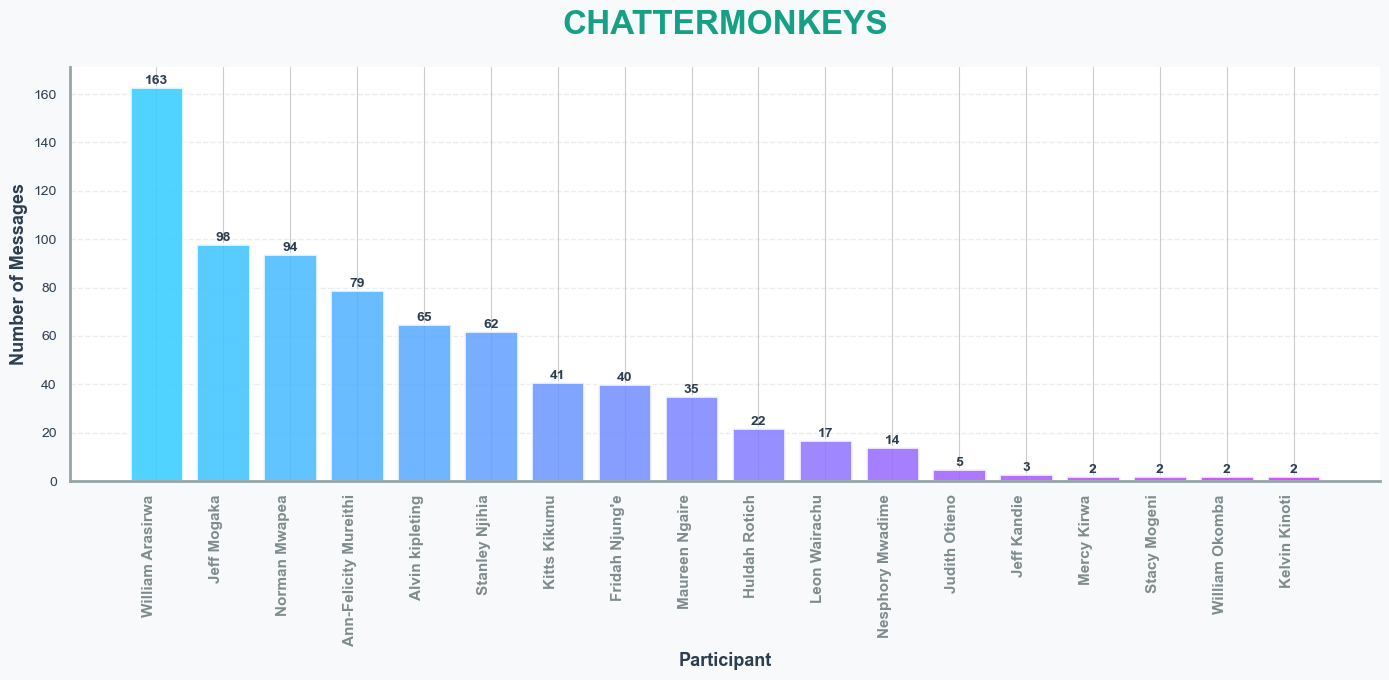

In [829]:
# Get name value counts
name_counts = chatterbox_df['name'].value_counts()

# Save the counts into a dataframe and print them out
df_name_counts = name_counts.reset_index()
df_name_counts.columns = ['Participant', 'Number of Messages']
print(df_name_counts.to_string(index=False))

# Create figure with light theme
fig, ax = plt.subplots(figsize=(14, 7), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Palette
colors = plt.cm.cool(np.linspace(0.2, 0.8, len(name_counts)))

# Create bars 
bars = ax.bar(range(len(name_counts)), name_counts.values, 
               color=colors, 
               edgecolor='white', 
               linewidth=2,
               alpha=0.85)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, name_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value)}',
            ha='center', va='bottom',
            color='#2c3e50', fontsize=10, weight='bold')

# Styling
ax.set_xticks(range(len(name_counts)))
ax.set_xticklabels(name_counts.index, rotation=90, ha='right', color='#34495e', fontsize=11, weight='bold')
ax.set_ylabel("Number of Messages", color='#2c3e50', fontsize=13, weight='bold')
ax.set_xlabel("Participant", color='#2c3e50', fontsize=13, weight='bold')

# Grid 
ax.grid(axis='y', alpha=0.3, linestyle='--', color='#bdc3c7', linewidth=1)
ax.set_axisbelow(True)

# Spine styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('#95a5a6')
    ax.spines[spine].set_linewidth(2)

# Tick styling
ax.tick_params(colors='#7f8c8d', which='both', length=6, width=1.5)
ax.tick_params(axis='y', labelsize=10, colors='#2c3e50')

# Modern title with accent color
ax.text(0.5, 1.08, 'CHATTERMONKEYS', 
        transform=ax.transAxes,
        fontsize=24, 
        weight='bold',
        ha='center',
        color='#16a085',
        fontfamily='sans-serif')

plt.tight_layout()
plt.show()

*Observation:*

- William Arasirwa dominates the conversation with 163 messages, followed by Jeff Mogaka (98) and Norman Mwapea (myself) (94). Together, we account for a large chunk of the activity.
- Ann-Felicity Mureithi (my dear) (79), Alvin Kipleting (65), and Stanley Njihia (62) participate regularly but less intensely than the top three.
- Several students (Judith Otieno, Jeff Kandie, Mercy Kirwa, Stacy Mogeni, William Okomba, Kelvin Kinoti) have very few messages, some just 2–5, indicating minimal participation.

#### 2. day

CHAT ACTIVITY DISTRIBUTION BY DAY

      Day  Message Count  Percentage
  Tuesday            269       36.06
Wednesday            257       34.45
 Thursday            220       29.49




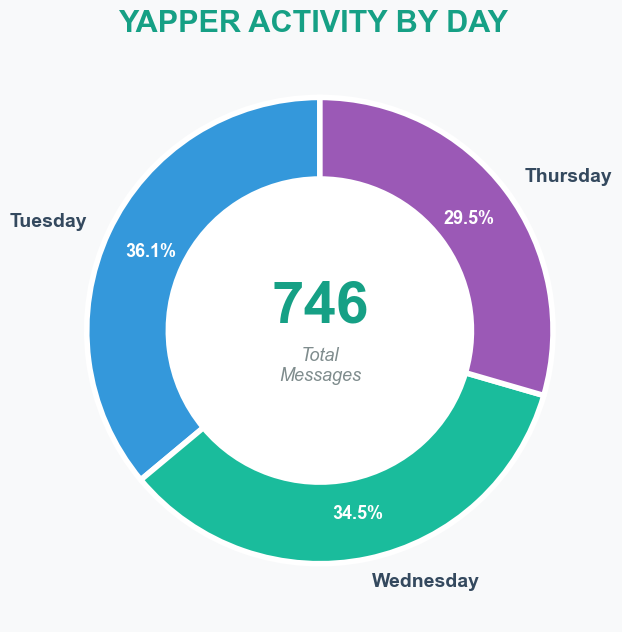

In [830]:
day_counts = chatterbox_df['day'].value_counts()

# Create a dataframe from day_counts
day_distribution = pd.DataFrame({
    'Day': day_counts.index,
    'Message Count': day_counts.values,
    'Percentage': (day_counts.values / day_counts.sum() * 100).round(2)
})

day_distribution = pd.concat([day_distribution], ignore_index=True)

# Display the dataframe
print("CHAT ACTIVITY DISTRIBUTION BY DAY\n")
print(day_distribution.to_string(index=False))
print("\n")

# Create figure with light theme
fig, ax = plt.subplots(figsize=(6.5, 6.5), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Light modern palette - soft blues, teals, and purples
light_colors = ['#3498db', '#1abc9c', '#9b59b6', '#e74c3c', '#f39c12', '#16a085', '#2ecc71']
colors = light_colors[:len(day_counts)]

# Create donut chart 
wedges, texts, autotexts = ax.pie(
    day_counts.values,
    labels=day_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.35, edgecolor='white', linewidth=4),  
    textprops={'color': '#2c3e50', 'fontsize': 13, 'weight': 'bold'},
    pctdistance=0.80
)

# Style percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize=11
    autotext.set_weight('bold')

# Style day labels
for text in texts:
    text.set_color('#34495e')
    text.set_fontsize(14)
    text.set_weight('bold')

# Add center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.65, fc='#ffffff', linewidth=0)
ax.add_artist(centre_circle)

# Add center text with light theme colors
total_messages = day_counts.sum()
ax.text(0, 0.1, f'{total_messages}', 
        ha='center', va='center',
        fontsize=42, weight='bold', color='#16a085')
ax.text(0, -0.15, 'Total\nMessages', 
        ha='center', va='center',
        fontsize=13, color='#7f8c8d', style='italic')

# Title with modern styling
fig.text(0.5, 0.96, 'YAPPER ACTIVITY BY DAY', 
         ha='center',
         fontsize=22, 
         weight='bold',
         color='#16a085',
         fontfamily='sans-serif')

plt.tight_layout()
plt.show()

*Observation:*

- Tuesday is the busiest day with 36% of messages, followed closely by Wednesday (34%).
- Thursday sees slightly less activity (29%), but still substantial.

#### 3. hours_in_class

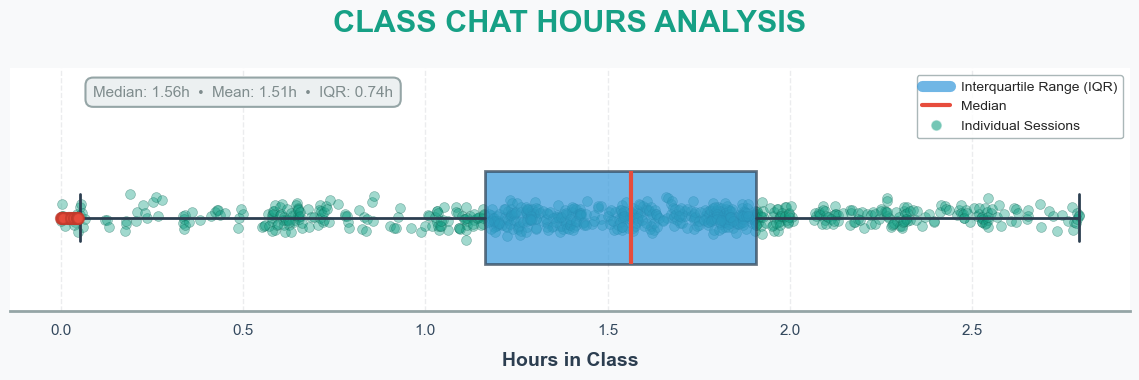

In [831]:
# Create figure
fig, ax = plt.subplots(figsize=(11.5, 4), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Create boxplot
box = ax.boxplot(chatterbox_df['hours_in_class'], 
                 vert=False,
                 patch_artist=True,
                 widths=0.5,
                 boxprops=dict(facecolor='#3498db', alpha=0.7, edgecolor='#2c3e50', linewidth=2),
                 whiskerprops=dict(color='#2c3e50', linewidth=2),
                 capprops=dict(color='#2c3e50', linewidth=2),
                 medianprops=dict(color='#e74c3c', linewidth=3),
                 flierprops=dict(marker='o', markerfacecolor='#e74c3c', markersize=8, 
                                markeredgecolor='#c0392b', markeredgewidth=1.5, alpha=0.7))

# Add swarm plot overlay for individual data points
y_positions = np.random.normal(1, 0.04, size=len(chatterbox_df))
ax.scatter(chatterbox_df['hours_in_class'], y_positions, 
           alpha=0.4, s=50, color='#16a085', edgecolor='#0e6655', linewidth=0.5,
           zorder=1)

# Calculate statistics
q1 = chatterbox_df['hours_in_class'].quantile(0.25)
q3 = chatterbox_df['hours_in_class'].quantile(0.75)
median = chatterbox_df['hours_in_class'].median()
mean = chatterbox_df['hours_in_class'].mean()
iqr = q3 - q1

# Add statistical annotations
stats_text = f"Median: {median:.2f}h  •  Mean: {mean:.2f}h  •  IQR: {iqr:.2f}h"
ax.text(0.5, 1.65, stats_text,
        transform=ax.transData,
        ha='center',
        fontsize=11,
        color='#7f8c8d',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', 
                 edgecolor='#95a5a6', linewidth=1.5))

# Styling
ax.set_xlabel("Hours in Class", color='#2c3e50', fontsize=14, weight='bold', labelpad=10)
ax.set_yticks([])
ax.set_ylim(0.5, 1.8)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--', color='#bdc3c7', linewidth=1)
ax.set_axisbelow(True)

# Spine styling
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
ax.spines['bottom'].set_color('#95a5a6')
ax.spines['bottom'].set_linewidth(2)

# Tick styling
ax.tick_params(colors='#34495e', which='both', labelsize=11, length=6, width=1.5)

# Title
ax.text(0.5, 1.15, 'CLASS CHAT HOURS ANALYSIS', 
        transform=ax.transAxes,
        fontsize=22, 
        weight='bold',
        ha='center',
        color='#16a085',
        fontfamily='sans-serif')

# Add legend for box plot elements
legend_elements = [
    plt.Line2D([0], [0], color='#3498db', lw=8, alpha=0.7, label='Interquartile Range (IQR)'),
    plt.Line2D([0], [0], color='#e74c3c', lw=3, label='Median'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#16a085', 
               markersize=8, alpha=0.6, label='Individual Sessions')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
         facecolor='white', edgecolor='#95a5a6', fontsize=10)

plt.tight_layout()
plt.show()

*Observation:*

- Median & Mean: The median is around 1.56 hours, slightly above the mean of 1.51 hours.
    - This means chats get more dense from middle of class towards the end; in line with ground truth because by this time, our brains are getting saturated and we need some form of reprieve.

- Interquartile Range (IQR): The IQR spans roughly 1.0h to 1.85h, showing that the middle 50% of sessions chats fall within this range.
    - Most sessions chats are clustered around 1.5 hours, further solidifying what the mean and median tells us.

- Outliers: There are a few short sessions near 0h. These are not outliers by definition but rather students who log into clss before time.
    - There are also some longer sessions beyond 2.5h, this happened when we were doing NLP, the session was longer than usual.

#### What do we say.

Overall Top 20 words:
[('jeff', 53), ('arasirwa', 23), ('ann', 22), ('norman', 18), ('leo', 13), ('tm', 12), ('nlp', 12), ('one', 10), ('ndio', 10), ('ata', 9), ('ako', 9), ('judith', 9), ('maureen', 9), ('kitts', 9), ('hio', 8), ('love', 7), ('damn', 7), ('phase', 7), ('like', 7), ('analysis', 7)]


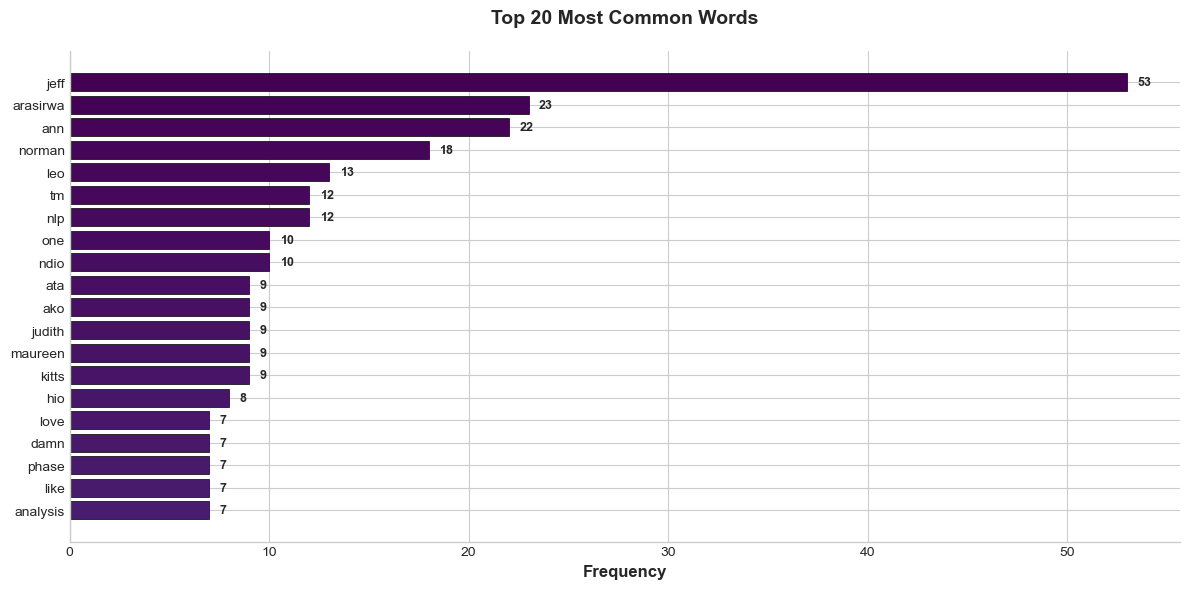

In [832]:
# Get most common words in class
all_tokens = [word for tokens in chatterbox_df["tokens"] for word in tokens]
fdist_all = FreqDist(all_tokens)

print("Overall Top 20 words:")
print(fdist_all.most_common(20))

# Visualize
top_20 = fdist_all.most_common(20)
words = [w[0] for w in top_20]
counts = [w[1] for w in top_20]

# Set style
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot
colors = plt.cm.viridis(range(len(words)))
bars = ax.barh(words[::-1], counts[::-1], color=colors[::-1], edgecolor='black', linewidth=0.5)

# Customize
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Common Words', fontsize=14, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts[::-1])):
    ax.text(count + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

*Observation:*

- Looking at our class chats, one name clearly stood out; Jeff. He was the main topic of discussion for the weak and was under fire from the class with friendly banter. He appears over fifty times! Way more than anyone else.
- Arasirwa, Ann, Norman, and a few others were the instigators for Jeff's unease. The ones keeping the chat alive and flowing.
- Interestingly, words like “NLP” and “TM” pop up, showing that amidst all the banter, we still stayed on track with our topic- Natural Language Processing. So even though the discussion had a friendly and interactive vibe, there was a strong academic thread running through it. We might be rowdy, but we know what's important.

#### Who says what the most.


Top 10 words for Alvin kipleting:
[('jeff', 10), ('norman', 5), ('arasirwa', 4), ('sahii', 3), ('itabidi', 3), ('eiii', 3), ('rada', 3), ('wapi', 3), ('eka', 3), ('huyo', 2)]

Top 10 words for Ann-Felicity Mureithi:
[('jeff', 6), ('arasirwa', 5), ('norman', 4), ('laptop', 3), ('jack', 3), ('nlp', 3), ('one', 2), ('year', 2), ('pretty', 2), ('stan', 2)]

Top 10 words for Fridah Njung'e:
[('jeff', 8), ('crying', 2), ('chill', 2), ('getting', 2), ('phase', 2), ('go', 2), ('child', 2), ('stenographer', 1), ('thought', 1), ('heard', 1)]

Top 10 words for Huldah Rotich:
[('sentimental', 3), ('william', 3), ('leo', 2), ('time', 2), ('movie', 2), ('itabidi', 2), ('tm', 2), ('two', 1), ('independent', 1), ('variables', 1)]

Top 10 words for Jeff Kandie:
[('ken', 1), ('walibor', 1), ('even', 1), ('sheng', 1)]

Top 10 words for Jeff Mogaka:
[('ngaire', 6), ('arasirwa', 5), ('ann', 4), ('judith', 3), ('damn', 3), ('mm', 3), ('halftime', 3), ('alvo', 3), ('jonte', 3), ('eh', 3)]

Top 10 words for 

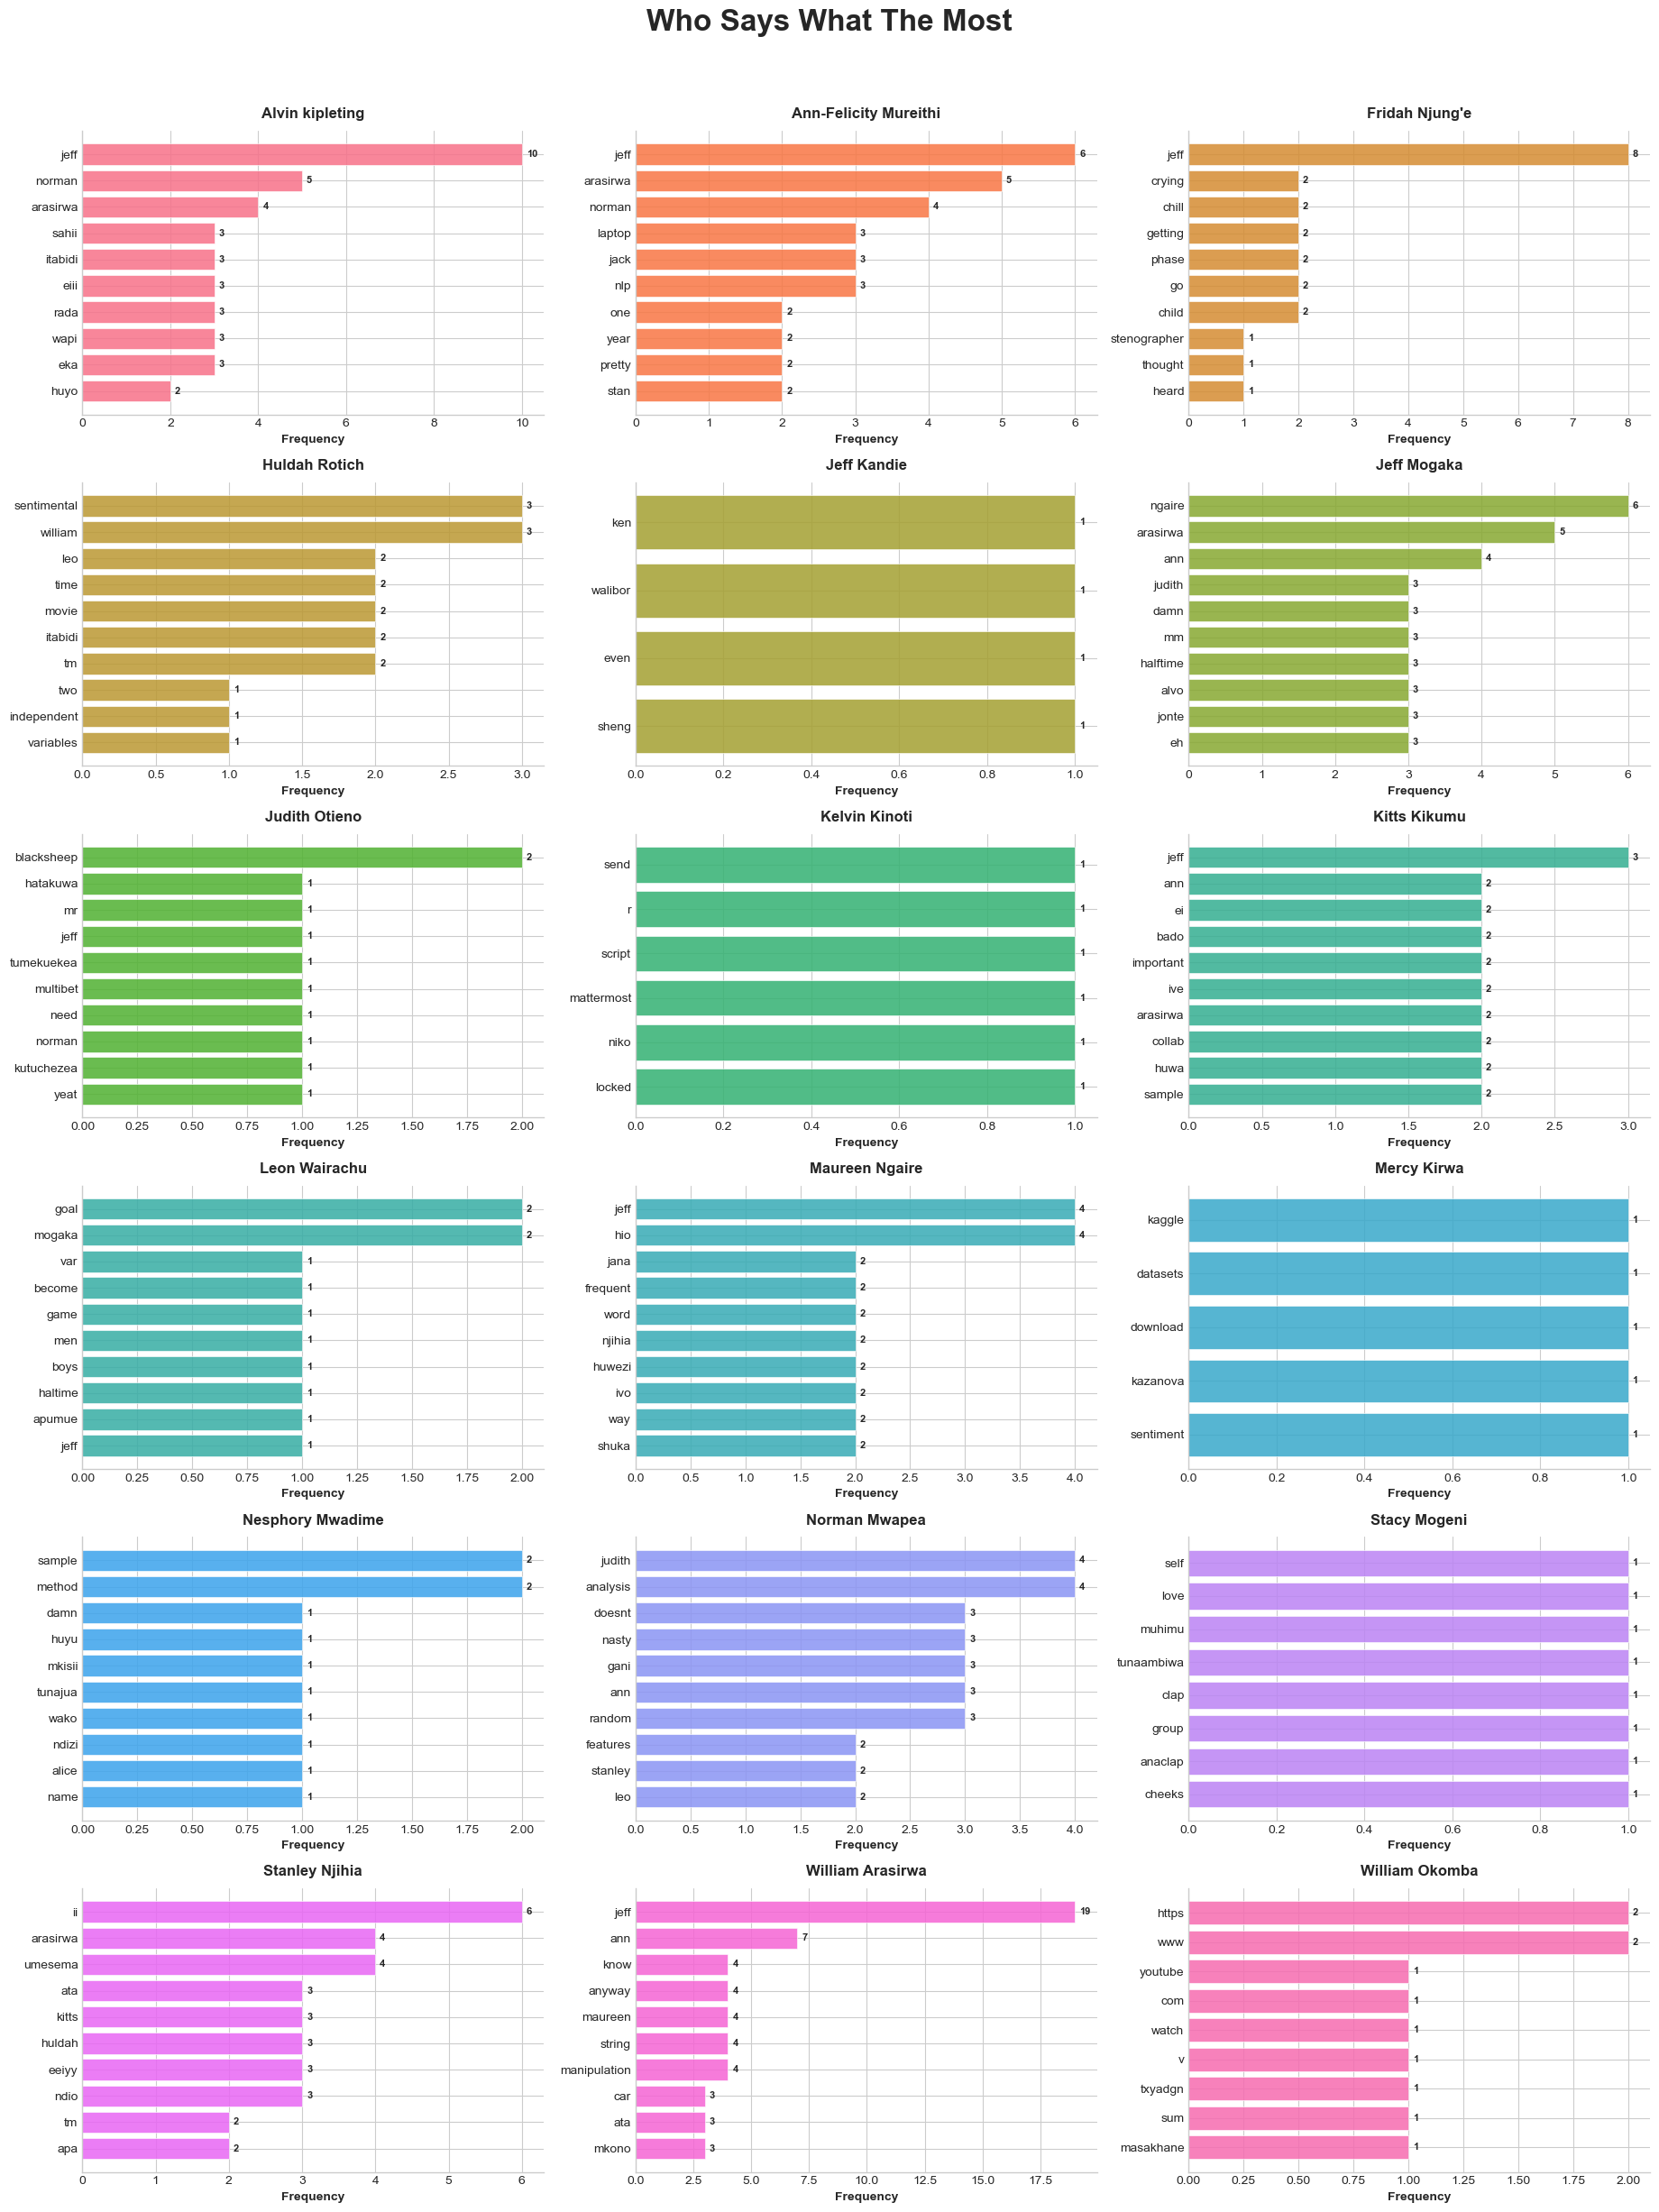

In [833]:
# Per-speaker frequency
speaker_fdists = {}

for speaker, group in chatterbox_df.groupby("name"):
    speaker_tokens = [word for tokens in group["tokens"] for word in tokens]
    speaker_fdists[speaker] = FreqDist(speaker_tokens)
    
    print(f"\nTop 10 words for {speaker}:")
    print(speaker_fdists[speaker].most_common(10))

# Create subplots for all speakers
n_speakers = len(speaker_fdists)
n_cols = 3  
n_rows = (n_speakers + n_cols - 1) // n_cols  

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18.5, 4*n_rows))  
axes = axes.flatten() if n_speakers > 1 else [axes]

# Color palette
colors = sns.color_palette("husl", n_speakers)

for idx, (speaker, fdist) in enumerate(speaker_fdists.items()):
    ax = axes[idx]
    
    # Get top 10 words
    top_10 = fdist.most_common(10)
    words = [w[0] for w in top_10]
    counts = [w[1] for w in top_10]
    
    # Create horizontal bars
    bars = ax.barh(words[::-1], counts[::-1], color=colors[idx],
                   edgecolor='white', linewidth=0.5, alpha=0.85)
    
    # Customize
    ax.set_xlabel('Frequency', fontdict={'size': 10, 'weight': 'semibold'})
    ax.set_title(f'{speaker}', fontdict={'size': 12, 'weight': 'semibold'}, pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add labels on bars
    for bar, count in zip(bars, counts[::-1]):
        ax.text(count + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count:,}', va='center', fontdict={'size': 8, 'weight': 'semibold'})

plt.suptitle('Who Says What The Most', fontsize=24, fontweight= 'bold', y=1.02)
plt.tight_layout()
plt.show()

*Observation:*

- Zooming into the chat by individual participants, class dynamics start to take shape. We all leaft a unique communication fingerprint; a trail of words that shows what they gravitated toward or emphasized.
- Jeff's name pops up across multiple participants’ charts, painting him as a central figure in the conversations. 
- William Arasiirwa is different: his messages orbit around content-heavy words and Jeff (obviously) with words like “know,” “anyway,” “NLP,” and “manipulation.” 
- Norman and Stacy, on the other hand, leaned more technical- dropping terms like “analysis,” “data,” “random,” “features,” and “drop.”
- Mercy and Maureen kept things grounded in the practical side of projects with words like “kaggle,” “download,” “word,” and “project” reveal a dataset-focused approach. Maureen was asking for clarifications mostly and help on what project we were tackling.
- Then you’ve got Fridah, Ann, and Alvin, whose word choices (“crying,” “pretty,” “bana,” “ati”) added a lighter, social tone.

### TF-IDF

In [834]:
# TF-IDF on tokens
vectorizer = TfidfVectorizer(analyzer=lambda x: x, dtype=float)

# Fit & transform using tokens column
X = vectorizer.fit_transform(chatterbox_df["tokens"])

# Build DataFrame
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names, index=chatterbox_df.index)

# Aggregate TF-IDF by speaker
student_tfidf = tfidf_df.groupby(chatterbox_df["name"]).mean()

# Aggregate TF-IDF by day 
day_tfidf = tfidf_df.groupby(chatterbox_df["day"]).mean()

# Get top N terms
def top_terms(tfidf_group, top_n=10):
    return (
        tfidf_group
        .apply(lambda row: row.sort_values(ascending=False).head(top_n).to_dict(), axis=1)
    )

# Top 10 terms per student
student_top_terms = top_terms(student_tfidf, top_n=10)

# Top 10 terms per day
day_top_terms = top_terms(day_tfidf, top_n=10)

print("Top terms per student:\n", student_top_terms)
print("\nTop terms per day:\n", day_top_terms)

Top terms per student:
 name
Alvin kipleting                           {'jeff': 0.04150955985025846, 'norman': 0.039762580892013545, 'eiii': 0.03765854132211101, 'eka': 0.031306187253545587, 'rada': 0.03072772287225879, 'wapi': 0.026114435905289526, 'arasirwa': 0.024775750484070387, 'sahii': 0.02331967297707623, 'huyo': 0.020692941299486373, 'hutaki': 0.01613242129697578}
Ann-Felicity Mureithi         {'arasirwa': 0.034847970508601014, 'laptop': 0.026711103486555095, 'norman': 0.026350484137456744, 'jeff': 0.025355053096075737, 'jack': 0.024447057266116488, 'nlp': 0.0235575600227076, 'unacompensate': 0.020344138741872807, 'pretty': 0.020057157799735402, 'others': 0.01887361984345761, 'die': 0.01762746746548649}
Fridah Njung'e                                                             {'jeff': 0.04660274220572817, 'crying': 0.031173722155472827, 'chill': 0.025198391764462535, 'stenographer': 0.025, 'waaaaah': 0.025, 'roundabout': 0.025, 'utamspank': 0.025, 'kill': 0.02072308150091115, 

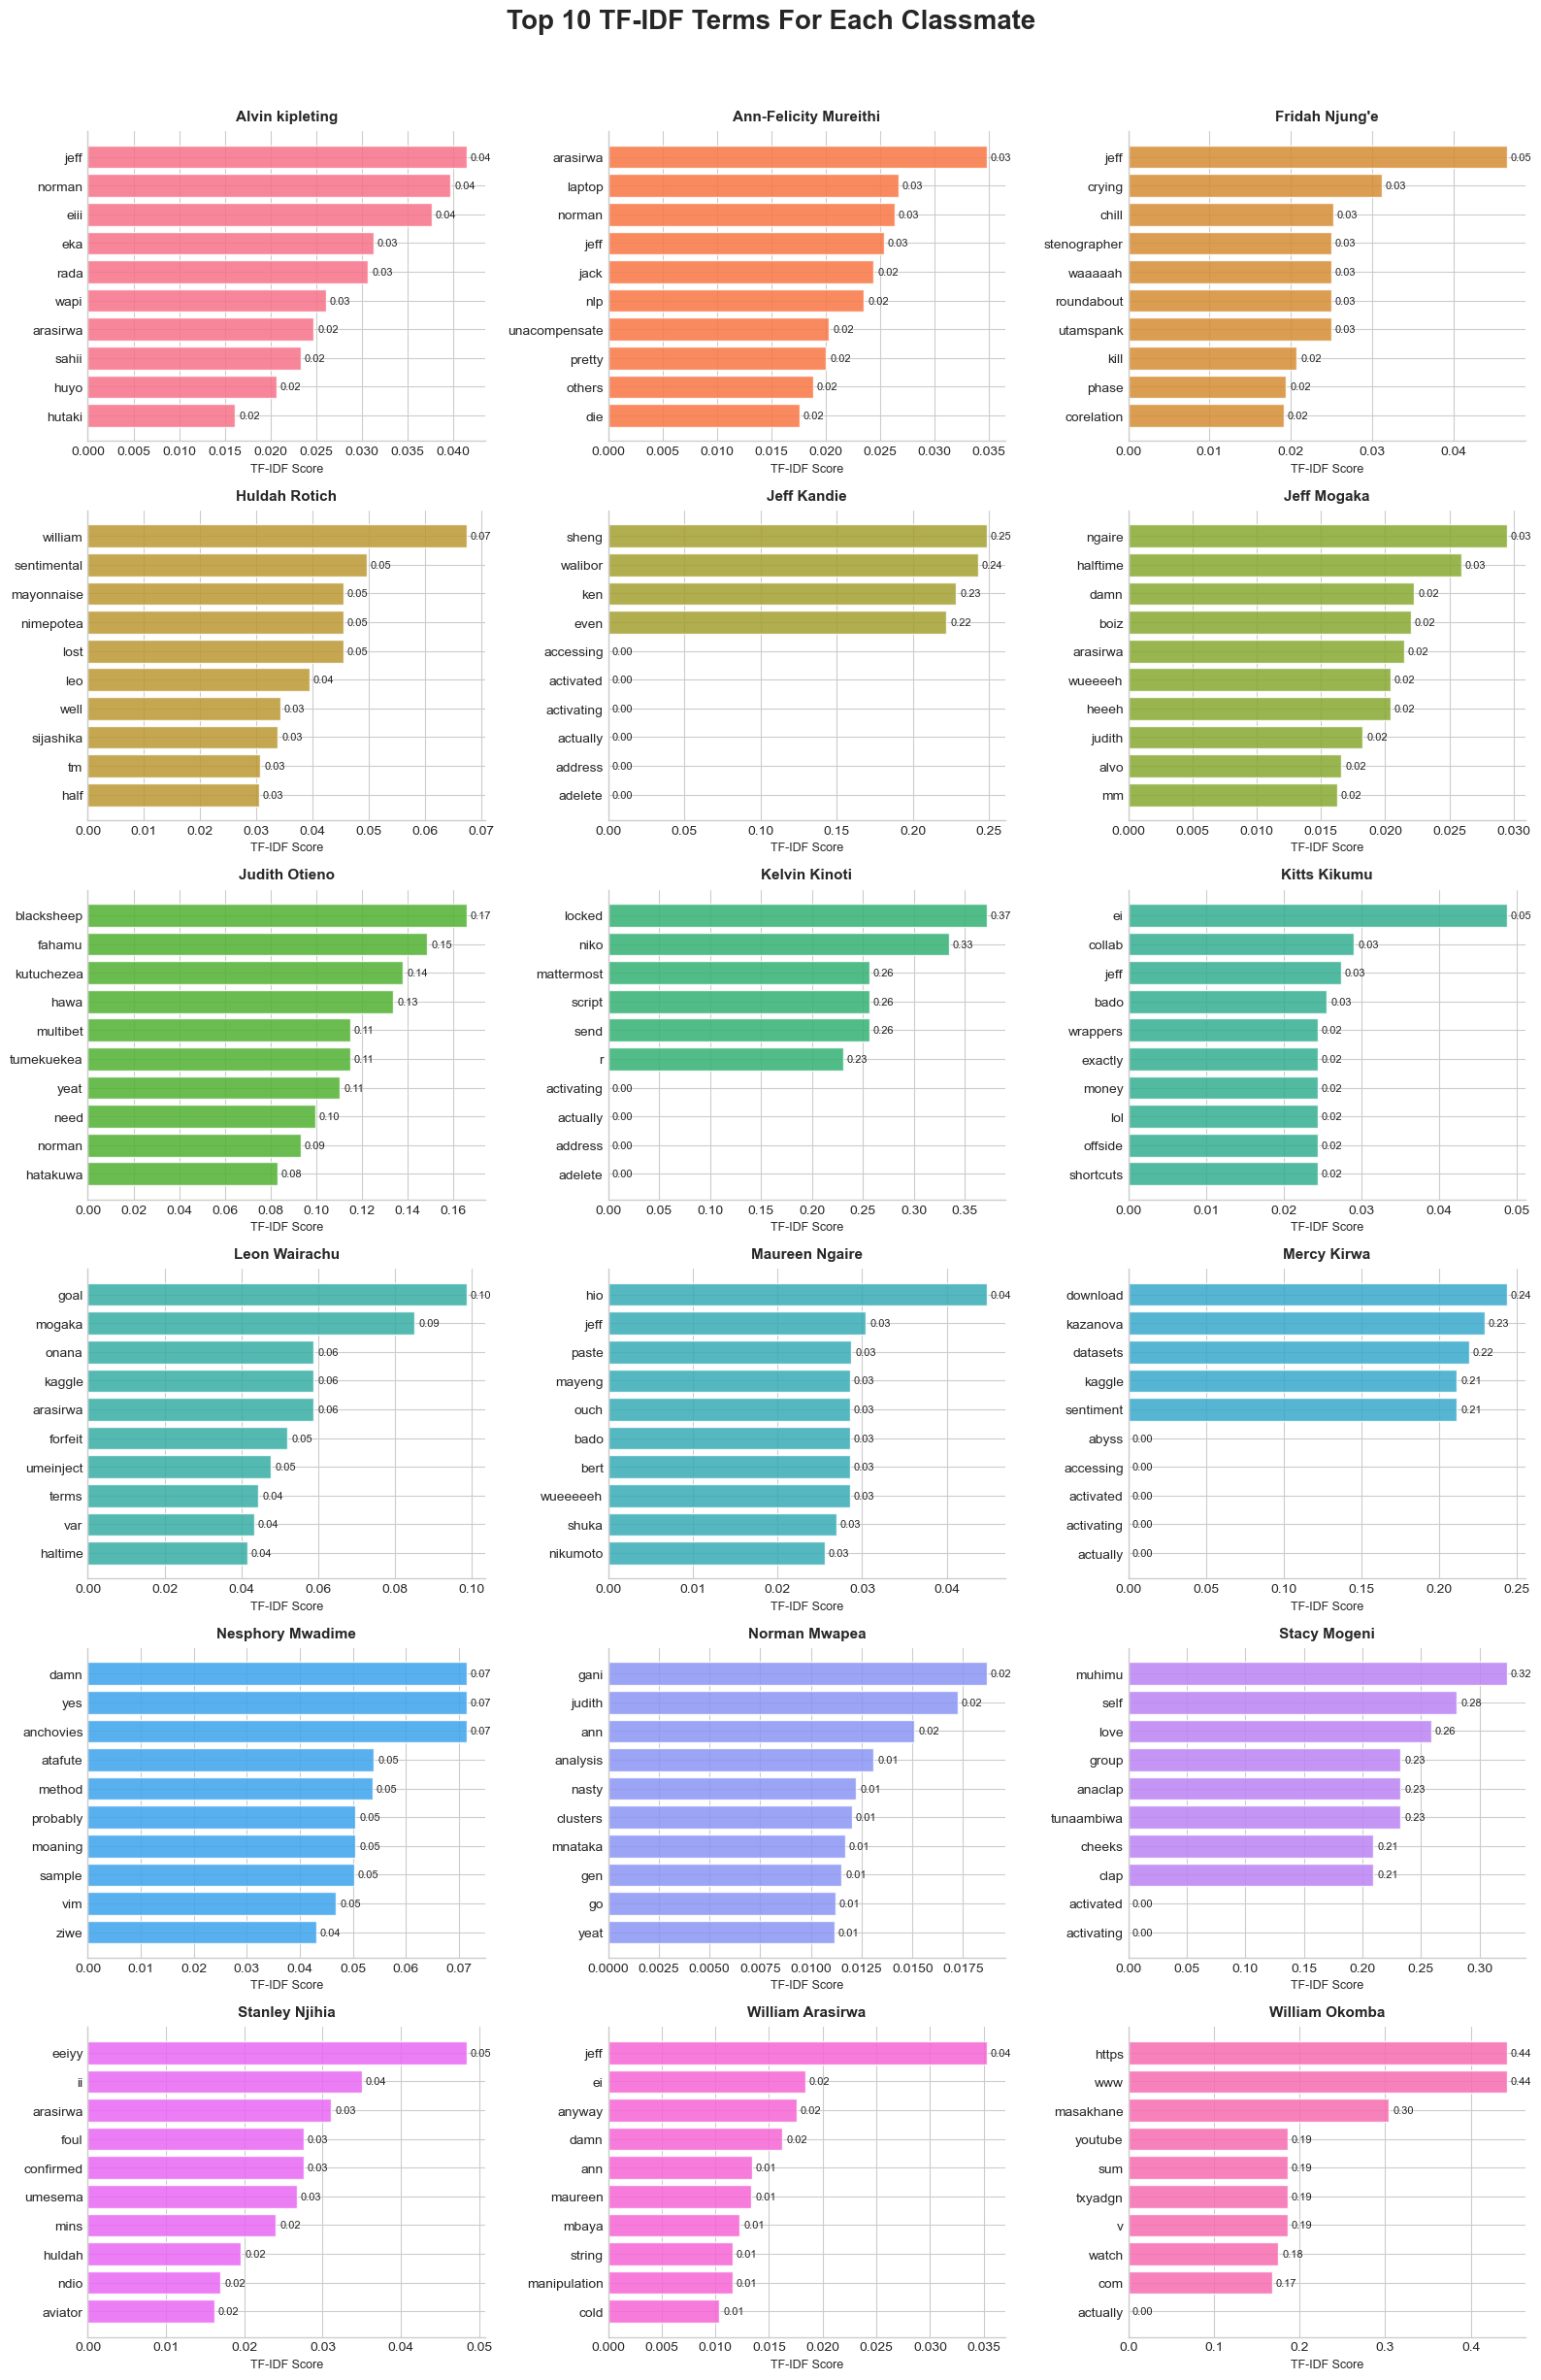

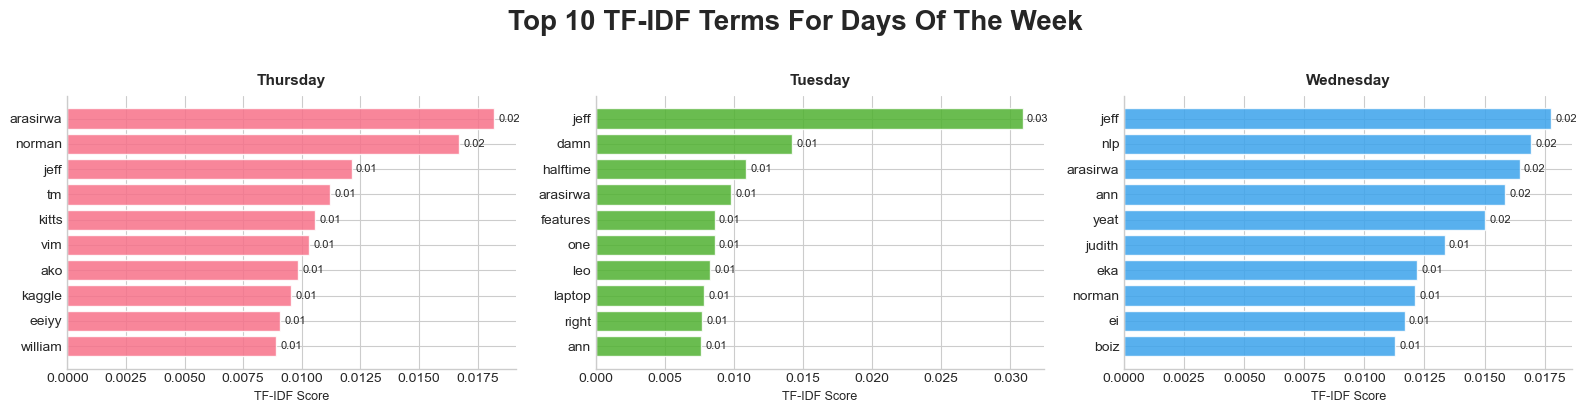

In [835]:
def plot_top_terms(tfidf_group, top_n=10, n_cols=3, title=None):

    '''
        Visualize TF-IDF
    '''
    
    n_groups = len(tfidf_group)
    n_rows = (n_groups + n_cols - 1) // n_cols

    # Palette
    palette = sns.color_palette("husl", n_groups)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()

    for i, (ax, (idx, row)) in enumerate(zip(axes, tfidf_group.iterrows())):
        # Get top terms
        top = row.sort_values(ascending=False).head(top_n)
        terms = top.index
        scores = top.values

        # Horizontal bar plots
        ax.barh(terms[::-1], scores[::-1], color=palette[i], alpha=0.85, edgecolor="white")
        ax.set_title(idx, fontsize=11, fontweight="bold", pad=8)
        ax.set_xlabel("TF-IDF Score", fontsize=9)

        # Add values on bars
        for y, v in enumerate(scores[::-1]):
            ax.text(v + max(scores)*0.01, y, f"{v:.2f}", va="center", fontsize=8)

        # Style
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # Hide unused axes
    for ax in axes[len(tfidf_group):]:
        ax.set_visible(False)

    # Title handling
    if title is None:
        title = f"Top {top_n} TF-IDF Terms For Each Classmate"
    plt.suptitle(title, fontsize=20, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

# For classmates
plot_top_terms(student_tfidf, top_n=10, n_cols=3)

# For days
plot_top_terms(day_tfidf, top_n=10, n_cols=3, title="Top 10 TF-IDF Terms For Days Of The Week")

*Observation:*

Our chats are a rich blend of academic, technical, and social communication. Each of us brings a distinct voice, but common names and playful expressions bind the group’s interaction style together.

### N-Grams

In [836]:
# Flatten all tokens
all_tokens = [word for tokens in chatterbox_df["tokens"] for word in tokens]

# Bigrams
bigrams = list(ngrams(all_tokens, 2))
bigram_freq = FreqDist(bigrams)

print("Top 20 Bigrams:")
print(bigram_freq.most_common(20))

# Trigrams
trigrams = list(ngrams(all_tokens, 3))
trigram_freq = FreqDist(trigrams)

print("\nTop 20 Trigrams:")
print(trigram_freq.most_common(20))


Top 20 Bigrams:
[(('one', 'year'), 5), (('https', 'www'), 4), (('string', 'manipulation'), 4), (('random', 'state'), 4), (('jeff', 'ako'), 3), (('pull', 'hair'), 3), (('sentiment', 'analysis'), 3), (('eka', 'yeat'), 3), (('ann', 'jeff'), 2), (('mkono', 'left'), 2), (('self', 'love'), 2), (('arasirwa', 'umesema'), 2), (('mbona', 'uspank'), 2), (('clap', 'cheeks'), 2), (('damn', 'wueeeeh'), 2), (('chupa', 'lotion'), 2), (('testing', 'gag'), 2), (('gag', 'reflex'), 2), (('eh', 'eh'), 2), (('man', 'city'), 2)]

Top 20 Trigrams:
[(('testing', 'gag', 'reflex'), 2), (('nlp', 'string', 'manipulation'), 2), (('https', 'www', 'kaggle'), 2), (('www', 'kaggle', 'com'), 2), (('kaggle', 'com', 'datasets'), 2), (('chuma', 'changu', 'ki'), 2), (('need', 'lessons', 'presentation'), 1), (('lessons', 'presentation', 'mnaskia'), 1), (('presentation', 'mnaskia', 'reverb'), 1), (('mnaskia', 'reverb', 'wakubwa'), 1), (('reverb', 'wakubwa', 'eeeeh'), 1), (('wakubwa', 'eeeeh', 'peris'), 1), (('eeeeh', 'peris',

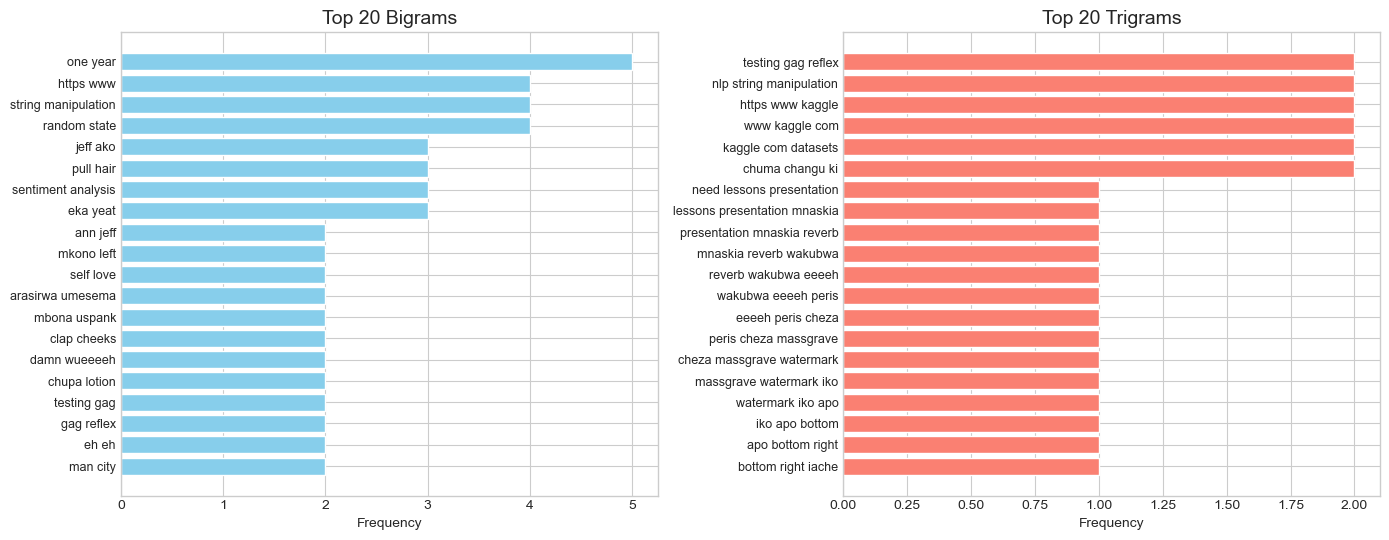

In [837]:
# Helper to format n-grams
def format_ngrams(ngram_counts):
    return [" ".join(ngram) for ngram, _ in ngram_counts], [count for _, count in ngram_counts]

# Get top 20 for each
top_bigrams = bigram_freq.most_common(20)
top_trigrams = trigram_freq.most_common(20)

# Format
bigram_labels, bigram_values = format_ngrams(top_bigrams)
trigram_labels, trigram_values = format_ngrams(top_trigrams)

# Subplots: 2 columns, auto rows
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
axes = axes.flatten()

# Bigram subplot
axes[0].barh(bigram_labels[::-1], bigram_values[::-1], color="skyblue")
axes[0].set_title("Top 20 Bigrams", fontsize=14)

# Trigram subplot
axes[1].barh(trigram_labels[::-1], trigram_values[::-1], color="salmon")
axes[1].set_title("Top 20 Trigrams", fontsize=14)

# Common formatting
for ax in axes[:3]:
    ax.set_xlabel("Frequency")
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

*Observation:*

- The bigrams and trigrams capture the dual essence of the class culture and are consistent with findings from TF-IDF; a blend of academic curiosity and social vibrancy.
- We seitch effortlessly between technical jargon and humorous local expressions, revealing not just what we discuss, but how we connect, collaborate, and build community.

## TOPIC MODELING

Now that I understand what we say, who says it, and how we interact, the next step is to uncover the underlying themes driving our conversations.

Are there certain topics that consistently stand out- discussions that capture the our collective attention or shape the tone of interaction?

In [838]:
# Use TF-IDF matrix
n_topics = 2
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

def print_topics(model, feature_names, n_top_words=50):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print_topics(lda, feature_names)

Topic 0:
jeff norman damn ei nlp judith yeat ann ako ata know eka ndio wapi hio halftime boiz bado yes like love alvin eiii next leo ptsd kitu features go stan william mogaka vim bag mean mbona others cold yeah stuff word mbaya sitoboi dj jack kitts watu mic mr string

Topic 1:
arasirwa jeff tm one maureen ann year even gani eeiyy ngaire phase leo anyway goal laptop right mtu kwani pull better time kaggle mnaona mkono say offside lol heeeh wueeeeh itabidi rada diana stacy guys hair common analysis kaa sentiment amesema mwalimu long stanley mm uko infertile unataka sentimental taya



## CLUSTERING

### PCA

In [839]:
components_list = [10, 15, 20, 30, 50, 100]

results_pca = []

for n in components_list:
    pca = PCA(n_components=n, random_state=42)
    X_pca = pca.fit_transform(tfidf_df.values) 
    
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    
    results_pca.append((n, pca.explained_variance_ratio_.sum(), sil, db, ch))

print(f"{'Components':<12} {'Expl.Var':<10} {'Silhouette':<12} {'DB-Index':<10} {'CH-Score':<10}")
for n, var, sil, db, ch in results_pca:
    print(f"{n:<12} {var:.3f}      {sil:.3f}        {db:.3f}      {ch:.3f}")


Components   Expl.Var   Silhouette   DB-Index   CH-Score  
10           0.064      0.676        0.509      114.118
15           0.084      0.440        0.730      76.805
20           0.102      0.506        0.653      63.935
30           0.136      0.405        0.700      45.636
50           0.194      0.279        0.965      31.093
100          0.311      0.049        2.164      15.225


### SVD

In [840]:
# Range of components to test
components_list = [20, 30, 50, 100, 200]

results = []

for n in components_list:
    # SVD
    svd = TruncatedSVD(n_components=n, random_state=42)
    X_svd = svd.fit_transform(tfidf_df)
    
    # Clustering (you can change k)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_svd)
    
    # Metrics
    sil = silhouette_score(X_svd, labels)
    db = davies_bouldin_score(X_svd, labels)
    ch = calinski_harabasz_score(X_svd, labels)
    
    results.append((n, svd.explained_variance_ratio_.sum(), sil, db, ch))

# Pretty print
print(f"{'Components':<12} {'Expl.Var':<10} {'Silhouette':<12} {'DB-Index':<10} {'CH-Score':<10}")
for n, var, sil, db, ch in results:
    print(f"{n:<12} {var:.3f}      {sil:.3f}        {db:.3f}      {ch:.3f}")

Components   Expl.Var   Silhouette   DB-Index   CH-Score  
20           0.100      0.499        0.660      65.054
30           0.134      0.397        0.717      46.361
50           0.192      0.475        0.507      29.357
100          0.313      0.056        1.885      17.755
200          0.491      0.023        4.948      10.658


### EMBEDDINGS

In [841]:
# Prepare embeddings
svd = TruncatedSVD(n_components=20, random_state=42)
X_svd = svd.fit_transform(tfidf_df)

# Define clusterers
clusterers = {
    "KMeans (k=2)": KMeans(n_clusters=2, random_state=42, n_init=10),
    "Agglomerative (k=2)": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=2, metric='cosine')
}

results = []

# Fit and evaluate each algorithm
for name, model in clusterers.items():
    labels = model.fit_predict(X_svd)
    
    # Handle DBSCAN noise
    mask = labels != -1 if name == "DBSCAN" else slice(None)
    
    unique_labels = set(labels[mask])
    n_clusters = len(unique_labels)
    
    # Compute metrics only if 2 or more clusters exist
    if n_clusters < 2:
        sil, db, ch = np.nan, np.nan, np.nan
    else:
        sil = silhouette_score(X_svd[mask], labels[mask])
        db = davies_bouldin_score(X_svd[mask], labels[mask])
        ch = calinski_harabasz_score(X_svd[mask], labels[mask])
    
    results.append({
        "Algorithm": name,
        "Num Clusters": n_clusters,
        "Silhouette": sil,
        "DB Index": db,
        "CH Score": ch
    })

# Display Results
results_df = pd.DataFrame(results)
results_df

,Algorithm,Num Clusters,Silhouette,DB Index,CH Score
0,KMeans (k=2),2,0.484119,0.787855,63.385625
1,Agglomerative (k=2),2,0.484119,0.787855,63.385625
2,DBSCAN,2,0.682535,0.217564,53.386879


In [842]:
# Clustering
def cluster_analysis(X_embeds, df, tfidf_df, clusterers, top_terms_func, top_n=10):
    """
    Performs clustering, summarizes messages, participants, and top terms per cluster.
    
    Parameters:
        X_embeds : np.array or sparse matrix
            The feature matrix (SVD or TF-IDF embeddings)
        df : pd.DataFrame
            Original dataframe containing 'name', 'text', and 'clean_text'
        tfidf_df : pd.DataFrame
            TF-IDF matrix with terms as columns
        clusterers : dict
            Dictionary of cluster_name: sklearn_cluster_model
        top_terms_func : function
            Function to extract top terms per cluster
        top_n : int
            Number of top terms to return per cluster
    """
    
    results_summary = {}
    
    for name, model in clusterers.items():
        # Fit model and predict labels
        labels = model.fit_predict(X_embeds)
        df[f'{name}_cluster'] = labels  # store cluster labels
        
        print(f"\n===== {name} =====")
        # Number of messages per cluster
        print("Messages per cluster:")
        print(pd.Series(labels).value_counts())
        
        # Dominant participants per cluster
        cluster_participants = df.groupby([f'{name}_cluster', 'name']).size().unstack(fill_value=0)
        print("\nParticipants per cluster:")
        display(cluster_participants)
        
        # Sample a few messages per cluster
        print("\nSample messages per cluster:")
        for cluster in sorted(set(labels)):
            cluster_msgs = df[df[f'{name}_cluster'] == cluster]['clean_text']
            n_samples = min(5, len(cluster_msgs))
            print(f"\n--- Cluster {cluster} ---")
            for msg in cluster_msgs.sample(n_samples, random_state=42):
                print("-", msg)
        
        # Average TF-IDF vectors per cluster → top terms
        cluster_tfidf = tfidf_df.copy()
        cluster_tfidf['cluster'] = labels
        cluster_topics = cluster_tfidf.groupby('cluster').mean()
        top_terms_per_cluster = top_terms_func(cluster_topics, top_n=top_n)
        print("\nTop terms per cluster:")
        display(top_terms_per_cluster)
        
        results_summary[name] = {
            "labels": labels,
            "participants": cluster_participants,
            "top_terms": top_terms_per_cluster
        }
        
    return results_summary


# Define your clusterers
clusterers = {
    "KMeans": KMeans(n_clusters=2, random_state=42, n_init=10),
    "Agglomerative": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=2, metric='cosine')
}

# Run the analysis
results = cluster_analysis(X_svd, chatterbox_df, tfidf_df, clusterers, top_terms)


===== KMeans =====
Messages per cluster:
0    724
1     22
Name: count, dtype: int64

Participants per cluster:


name,Alvin kipleting,Ann-Felicity Mureithi,Fridah Njung'e,Huldah Rotich,Jeff Kandie,Jeff Mogaka,Judith Otieno,Kelvin Kinoti,Kitts Kikumu,Leon Wairachu,Maureen Ngaire,Mercy Kirwa,Nesphory Mwadime,Norman Mwapea,Stacy Mogeni,Stanley Njihia,William Arasirwa,William Okomba
KMeans_cluster,,,,,,,,,,,,,,,,,,
0,61,74,39,22,3,93,5,2,39,16,35,2,14,94,2,58,163,2
1,4,5,1,0,0,5,0,0,2,1,0,0,0,0,0,4,0,0



Sample messages per cluster:

--- Cluster 0 ---
- bado tensors
- even sheng
- leo saa nane
- 
- hehehehe wananifukuza right home

--- Cluster 1 ---
- arasirwa applying clustering shawries
- arasirwa throwing hands today
- arasirwa mapenzi yashakudhulumu maisha haya cinema
- arasirwa umesema uyo hermaphrodite
- arasirwa

Top terms per cluster:


cluster
0                            {'jeff': 0.020892986957090232, 'norman': 0.011748028861719668, 'ann': 0.01036811561478472, 'damn': 0.008050810735133427, 'nlp': 0.007256573082048755, 'leo': 0.007175639269202251, 'ei': 0.006906077348066298, 'one': 0.0064265825139475565, 'tm': 0.006360596855404515, 'maureen': 0.006042276488871589}
1    {'arasirwa': 0.48341674624432546, 'shawries': 0.04246688708341728, 'umesema': 0.040472027336917946, 'tulia': 0.03826662230889635, 'thanos': 0.03826662230889635, 'hurt': 0.03826662230889635, 'unacompensate': 0.03757109302257883, 'wimbo': 0.03702109209091234, 'tools': 0.034102247983432886, 'unasema': 0.033719328207441925}
dtype: object


===== Agglomerative =====
Messages per cluster:
0    724
1     22
Name: count, dtype: int64

Participants per cluster:


name,Alvin kipleting,Ann-Felicity Mureithi,Fridah Njung'e,Huldah Rotich,Jeff Kandie,Jeff Mogaka,Judith Otieno,Kelvin Kinoti,Kitts Kikumu,Leon Wairachu,Maureen Ngaire,Mercy Kirwa,Nesphory Mwadime,Norman Mwapea,Stacy Mogeni,Stanley Njihia,William Arasirwa,William Okomba
Agglomerative_cluster,,,,,,,,,,,,,,,,,,
0,61,74,39,22,3,93,5,2,39,16,35,2,14,94,2,58,163,2
1,4,5,1,0,0,5,0,0,2,1,0,0,0,0,0,4,0,0



Sample messages per cluster:

--- Cluster 0 ---
- bado tensors
- even sheng
- leo saa nane
- 
- hehehehe wananifukuza right home

--- Cluster 1 ---
- arasirwa applying clustering shawries
- arasirwa throwing hands today
- arasirwa mapenzi yashakudhulumu maisha haya cinema
- arasirwa umesema uyo hermaphrodite
- arasirwa

Top terms per cluster:


cluster
0                            {'jeff': 0.020892986957090232, 'norman': 0.011748028861719668, 'ann': 0.01036811561478472, 'damn': 0.008050810735133427, 'nlp': 0.007256573082048755, 'leo': 0.007175639269202251, 'ei': 0.006906077348066298, 'one': 0.0064265825139475565, 'tm': 0.006360596855404515, 'maureen': 0.006042276488871589}
1    {'arasirwa': 0.48341674624432546, 'shawries': 0.04246688708341728, 'umesema': 0.040472027336917946, 'tulia': 0.03826662230889635, 'thanos': 0.03826662230889635, 'hurt': 0.03826662230889635, 'unacompensate': 0.03757109302257883, 'wimbo': 0.03702109209091234, 'tools': 0.034102247983432886, 'unasema': 0.033719328207441925}
dtype: object


===== DBSCAN =====
Messages per cluster:
 0    714
-1     27
 1      5
Name: count, dtype: int64

Participants per cluster:


name,Alvin kipleting,Ann-Felicity Mureithi,Fridah Njung'e,Huldah Rotich,Jeff Kandie,Jeff Mogaka,Judith Otieno,Kelvin Kinoti,Kitts Kikumu,Leon Wairachu,Maureen Ngaire,Mercy Kirwa,Nesphory Mwadime,Norman Mwapea,Stacy Mogeni,Stanley Njihia,William Arasirwa,William Okomba
DBSCAN_cluster,,,,,,,,,,,,,,,,,,
-1,2,0,1,0,1,0,0,0,1,2,0,1,0,5,0,6,8,0
0,63,79,39,22,2,98,5,2,38,15,35,1,14,89,2,56,152,2
1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0



Sample messages per cluster:

--- Cluster -1 ---
- 
- 
- 
- 
- 

--- Cluster 0 ---
- jeff wanna climb decision tree
- ndiposa
- var goal
- want see common words common topics talks
- sahii tm ako barry allen mode

--- Cluster 1 ---
- ei
- ei
- ei
- ei
- ei

Top terms per cluster:


cluster
-1                                                                                                                                             {'abyss': 0.0, 'accessing': 0.0, 'activated': 0.0, 'activating': 0.0, 'actually': 0.0, 'address': 0.0, 'adelete': 0.0, 'adults': 0.0, 'aende': 0.0, 'affecting': 0.0}
 0    {'jeff': 0.021773391815304605, 'arasirwa': 0.015230486671473076, 'norman': 0.011912567081071485, 'ann': 0.01051332731807302, 'damn': 0.008163567188006444, 'nlp': 0.007358205758267925, 'leo': 0.007276138418630854, 'one': 0.006516590672406205, 'tm': 0.006449680844976007, 'maureen': 0.006126902210004244}
 1                                                                                                                                                    {'ei': 1.0, 'zygot': 0.0, 'abyss': 0.0, 'accessing': 0.0, 'activated': 0.0, 'activating': 0.0, 'actually': 0.0, 'address': 0.0, 'adelete': 0.0, 'adults': 0.0}
dtype: object

In [843]:
# # --- 1. Define TF-IDF with dampening ---
# def create_dampened_tfidf(df, text_col='clean_text', weights_dict=None):
#     """
#     Vectorizes text and dampens specific token weights.
    
#     weights_dict: dict of {token: scale}, e.g. {'eii': 0.2}
#     """
#     vectorizer = TfidfVectorizer()
#     X_tfidf = vectorizer.fit_transform(df[text_col])
#     tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    
#     if weights_dict:
#         for token, scale in weights_dict.items():
#             if token in tfidf_df.columns:
#                 tfidf_df[token] = tfidf_df[token] * scale
#     return tfidf_df, vectorizer

# # --- 2. Compute SVD embeddings ---
# def compute_svd(X_tfidf, n_components=20):
#     svd = TruncatedSVD(n_components=n_components, random_state=42)
#     X_svd = svd.fit_transform(X_tfidf)
#     return X_svd

# # --- 3. Extract top terms per cluster ---
# def top_terms(cluster_topics, top_n=10):
#     top_terms_dict = {}
#     for cluster in cluster_topics.index:
#         top_cols = cluster_topics.loc[cluster].sort_values(ascending=False).head(top_n).index.tolist()
#         top_terms_dict[cluster] = top_cols
#     return pd.DataFrame(top_terms_dict)

# # --- 4. Clustering workflow ---
# def cluster_analysis(X_embeds, df, tfidf_df, clusterers, top_terms_func, top_n=10):
#     results_summary = {}
#     for name, model in clusterers.items():
#         labels = model.fit_predict(X_embeds)
#         df[f'{name}_cluster'] = labels
        
#         print(f"\n===== {name} =====")
#         print("Messages per cluster:")
#         print(pd.Series(labels).value_counts())
        
#         cluster_participants = df.groupby([f'{name}_cluster', 'name']).size().unstack(fill_value=0)
#         print("\nParticipants per cluster:")
#         display(cluster_participants)
        
#         print("\nSample messages per cluster:")
#         for cluster in sorted(set(labels)):
#             cluster_msgs = df[df[f'{name}_cluster'] == cluster]['clean_text']
#             n_samples = min(5, len(cluster_msgs))
#             print(f"\n--- Cluster {cluster} ---")
#             for msg in cluster_msgs.sample(n_samples, random_state=42):
#                 print("-", msg)
        
#         cluster_tfidf = tfidf_df.copy()
#         cluster_tfidf['cluster'] = labels
#         cluster_topics = cluster_tfidf.groupby('cluster').mean()
#         top_terms_per_cluster = top_terms_func(cluster_topics, top_n=top_n)
#         print("\nTop terms per cluster:")
#         display(top_terms_per_cluster)
        
#         results_summary[name] = {
#             "labels": labels,
#             "participants": cluster_participants,
#             "top_terms": top_terms_per_cluster
#         }
        
#     return results_summary

# # --- 5. Run full workflow ---
# # Define token dampening
# weights_dict = {'eii': 0.2}

# # Create TF-IDF with dampened tokens
# tfidf_df_dampened, vectorizer = create_dampened_tfidf(chatterbox_df, weights_dict=weights_dict)

# # Compute SVD embeddings
# X_svd_dampened = compute_svd(tfidf_df_dampened, n_components=20)

# # Define clusterers
# clusterers = {
#     "KMeans": KMeans(n_clusters=2, random_state=42, n_init=10),
#     "Agglomerative": AgglomerativeClustering(n_clusters=2),
#     "DBSCAN": DBSCAN(eps=0.5, min_samples=3, metric='cosine')
# }

# # Run cluster analysis
# results = cluster_analysis(
#     X_svd_dampened,
#     chatterbox_df,
#     tfidf_df_dampened,
#     clusterers,
#     top_terms,
#     top_n=10
# )